In [ ]:
!pip install nltk wordcloud scikit-learn seaborn joblib

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import joblib

In [ ]:
nltk.download('stopwords')
STOPWORDS=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df=pd.read_csv('/content/sentiment.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().sum()


,0
review,0
sentiment,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.rename(columns={"review":"text","sentiment":"label"},inplace=True)
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
negations = ["not","no","nor"]
for w in negations:
    if w in STOPWORDS:
        STOPWORDS.remove(w)


In [ ]:
def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "wouldn't": "would not",
        "can't": "can not",
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "shouldn't": "should not",
        "couldn't": "could not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not"
    }

    for c, e in contractions.items():
        text = re.sub(rf"\b{c}\b", e, text, flags=re.IGNORECASE)

    return text


In [ ]:
def clean_text(s):
    s = str(s).lower()
    s=expand_contractions(s)
    s = re.sub(r"http\S+|www\S+|https\S+", "", s)
    s = re.sub(r"<.*?>", "", s)
    s = re.sub(r"[^a-zA-Z\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    tokens = [w for w in s.split() if w not in STOPWORDS]
    return " ".join(tokens)
df["clean_text"]=df["text"].apply(clean_text)
df.head()

,text,label,clean_text
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there's family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei's love time money visually stunn...


In [ ]:
df["label"]=df["label"].map({"positive":1,"negative":0})
df.head()

,text,label,clean_text
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there's family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei's love time money visually stunn...


Text(0.5, 1.0, 'Sentiment Distribution')

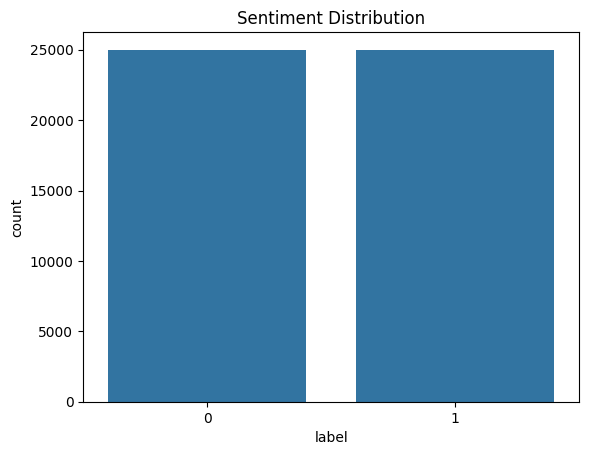

In [ ]:
sns.countplot(x="label",data=df)
plt.title("Sentiment Distribution")

In [ ]:
x=df["clean_text"]
y=df["label"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
tfidf=TfidfVectorizer(max_features=20000,ngram_range=(1,2))
x_train_tfidf=tfidf.fit_transform(x_train)
x_test_tfidf=tfidf.transform(x_test)

In [ ]:
model=LogisticRegression(max_iter=1000,solver='liblinear')
model.fit(x_train_tfidf,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
y_pred=model.predict(x_test_tfidf)

print("Accuracy :",accuracy_score(y_test,y_pred))
print("\n Classification Report :\n")
print(classification_report(y_test,y_pred))

Accuracy : 0.9044

 Classification Report :

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.90      0.92      0.91      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



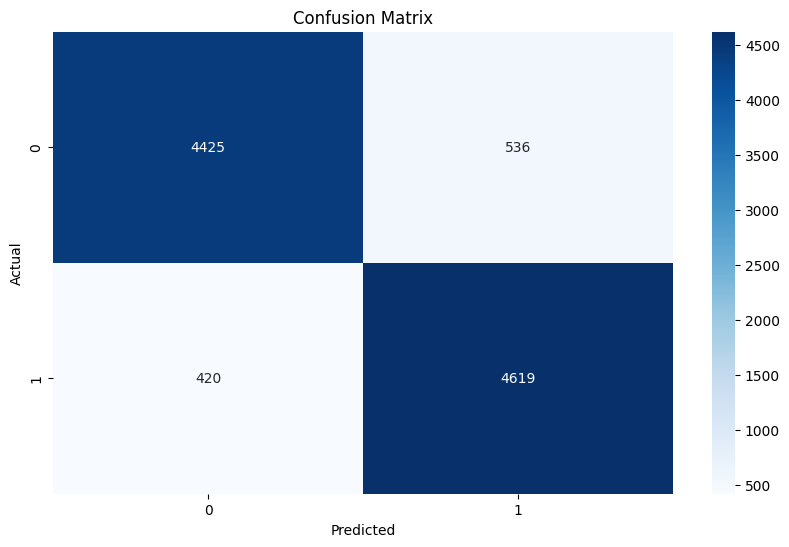

In [ ]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

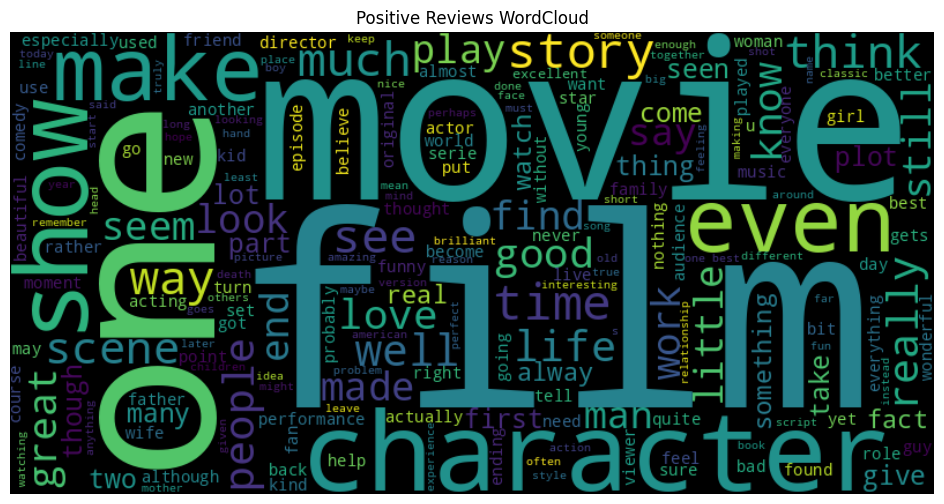

In [ ]:
pos_text=" ".join(df[df["label"]==1]["clean_text"])
wc_pos=WordCloud(width=800,height=400).generate(pos_text)
plt.figure(figsize=(12,6))
plt.imshow(wc_pos,interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews WordCloud")
plt.show()


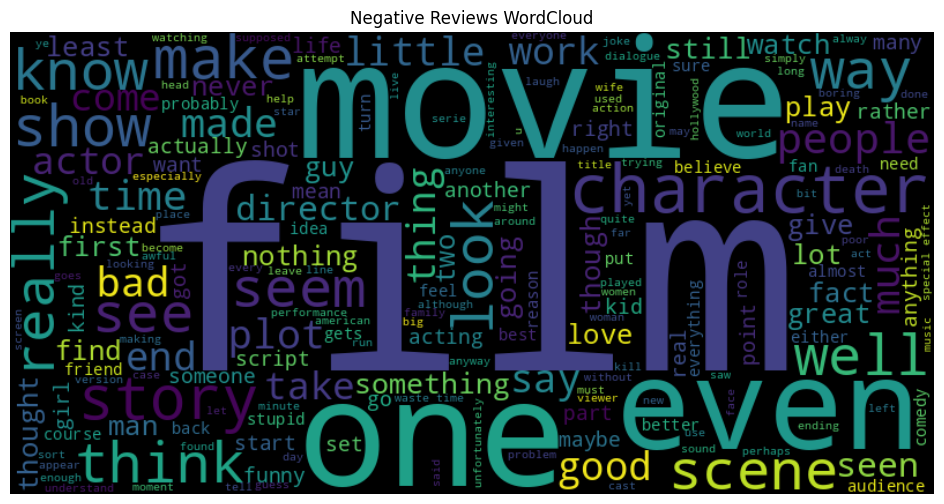

In [ ]:
neg_text=" ".join(df[df["label"]==0]["clean_text"])
wc_neg=WordCloud(width=800,height=400).generate(neg_text)
plt.figure(figsize=(12,6))
plt.imshow(wc_neg,interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews WordCloud")
plt.show()

In [ ]:
joblib.dump(model,"sentiment_model.joblib")
joblib.dump(tfidf,"tfidf_vectorizer.joblib")
print("Model & TF-IDF Vectorizer Saved !")

Model & TF-IDF Vectorizer Saved !


In [ ]:
def predict_sentiment(text):
  clean=clean_text(text)
  vectors=tfidf.transform([clean])
  pred=model.predict(vectors)[0]
  prob=model.predict_proba(vectors)[0][1]

  if pred==1:
    print("Sentiment : Positive")
  else:
    print("Sentiment : Negative")

  print(f"Confidence : {prob*100:.2f}")

In [ ]:
predict_sentiment("I wouldn't recommend this movie")
predict_sentiment("The acting was terrible")
predict_sentiment("This movie was a waste of time")
predict_sentiment("I hated this movie")
predict_sentiment("Completely disappointing experience")

Sentiment : Negative
Confidence : 17.02
Sentiment : Negative
Confidence : 2.11
Sentiment : Negative
Confidence : 1.10
Sentiment : Negative
Confidence : 22.99
Sentiment : Negative
Confidence : 6.50


In [ ]:
predict_sentiment("The movie was good")
predict_sentiment("Amazing acting and great story")
predict_sentiment("This film was enjoyable")
predict_sentiment("This movie was fantastic")

Sentiment : Positive
Confidence : 87.71
Sentiment : Positive
Confidence : 97.79
Sentiment : Positive
Confidence : 88.75
Sentiment : Positive
Confidence : 96.10


In [ ]:
from google.colab import files
files.download("sentiment_model.joblib")
files.download("tfidf_vectorizer.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>